In [1]:
import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler



# prep

In [2]:
filepath = '../car-dataset.csv'

def load_dataframe (filepath):
  return pd.read_csv(filepath)


def shuffle_rows (dataframe):
  return dataframe.sample(frac=1, random_state = 2).reset_index(drop=True)

def get_car_data(ratio = (0.8, 0.1, 0.1)): # filetype: .csv | list_type: pandas dataframe | ratio: (train - val - test)
  # tập train lớn nên chọn 8 1 1
  data = load_dataframe(filepath)
  data = shuffle_rows(data)

  data_x = data.drop(columns=['Price'])
  data_y = data['Price']

  train_size = int(len(data) * ratio[0])
  val_size = int(len(data) * ratio[1])
  test_size = int(len(data) * ratio[2])

  x_train = data_x[:train_size]
  y_train = data_y[:train_size]

  x_val = data_x[train_size:train_size+val_size]
  y_val = data_y[train_size:train_size+val_size]

  x_test = data_x[train_size+val_size:]
  y_test = data_y[train_size+val_size:]


  return x_train, y_train, x_val, y_val, x_test, y_test

df = load_dataframe(filepath)

df = shuffle_rows(df)

x_train, y_train, x_val, y_val, x_test, y_test = get_car_data()

In [3]:
x_train   

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num
0,Mercedes-Benz,GLE Class,59_25,59_25$$373,2021,5,White,2019.0,Coupe,4987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
1,Vauxhall,Corsa,94_9,94_9$$3352,2018,8,Black,2015.0,Hatchback,35345,...,94.0,0,2510.0,1481.0,1944.0,4021.0,83.1 mpg,113 mph,5.0,5.0
2,Nissan,350 Z,64_1,64_1$$57,2018,8,NaN,2005.0,Coupe,64000,...,276.0,NaN,2650.0,1320.0,1815.0,4310.0,24.8 mpg,155 mph,2.0,2.0
3,Ford,Fiesta,29_13,29_13$$1409,2018,8,Blue,2007.0,Hatchback,104155,...,NaN,250,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
4,Ford,C-Max,29_2,29_2$$689,2018,5,Black,2012.0,MPV,71000,...,113.0,30,2850.0,1626.0,2067.0,4380.0,61.4 mpg,114 mph,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,Volvo,XC70,96_17,96_17$$156,2018,5,NaN,2016.0,Estate,37750,...,220.0,195,2815.0,1604.0,2119.0,4838.0,48.7 mpg,130 mph,5.0,5.0
214600,Citroen,C4,18_12,18_12$$973,2018,5,Black,2009.0,Hatchback,78000,...,90.0,30,2608.0,1458.0,1773.0,4260.0,64.2 mpg,112 mph,5.0,5.0
214601,Audi,A6,7_11,7_11$$2721,2021,5,Black,2019.0,Saloon,17000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0
214602,Ford,Fiesta,29_13,29_13$$4632,2021,5,Black,2019.0,Hatchback,22284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0


In [4]:
from sklearn.impute import KNNImputer


class DataPreprocessor:
    def __init__ (self):
        # num features truoc khi prep for step 2
        self.numeric_features = ['adv-year', 'adv-month', 'reg-year', 'runned-miles', 'engine-size', 'engine-power', 'annual-tax', 'wheelbase', 'length', 'width', 'height', 'average-mpg', 'top-speed', 'seat-num', 'door-num']
        self.drop_feats = ['color', 'genmodel-id', 'adv-id', 'adv-year', 'adv-month', 'reg-year', 'annual-tax', 'wheelbase', 'height', 'door-num']
        self.feats_with_most_nan = []
        self.NaN_ratio_threshold = 0.5 # >= x thi loai bo
        self.schema = pd.DataFrame([
            ['age', 'Float64', 'none', 'mean'],
            ['runned-miles', 'Float64', 'none', 'mean'],
            ['engine-size', 'Float64', 'none', 'mean'],
            ['engine-power', 'Float64', 'none', 'median'],
            ['width', 'Float64', 'none', 'median'],
            ['length', 'Float64', 'none', 'median'],
            ['average-mpg', 'Float64', 'none', 'median'],
            ['top-speed', 'Float64', 'none', 'median'],
            ['seat-num', 'Float64', 'one-hot', 'mode'],
            ['maker', 'Float64', 'target', 'mean'], # encode 
            ['genmodel', 'Float64', 'target', 'mean'], # encode 
            # ['color', 'Float64', 'target', 'mode'],
            ['bodytype', 'Float64', 'one-hot', 'mode'],
            ['gearbox', 'Float64', 'one-hot', 'mode'],
            ['fuel-type', 'Float64', 'one-hot', 'mode'],
        ])

        self.categorical_choices = {}
        self.encoded_cols = []
        self.continuous_cols = ['age', 'runned-miles', 'engine-size', 'engine-power', 'width', 'length', 'average-mpg', 'top-speed']

    def change_column_names (self, dataframe): #step 1
        dataframe = dataframe.copy()
        dataframe.columns = [col.lower().replace('_', '-') for col in dataframe.columns]
        return dataframe
    
    def perform_light_cleaning (self, dataframe): # step 2: loại bỏ đơn vị và chuyển đổi kiểu dữ liệu
        dataframe = dataframe.copy()
        for col in self.numeric_features:
            if col in dataframe.columns:
                dataframe[col] = dataframe[col].astype(str).str.extract(r'(\d+(?:\.\d+)?)')[0]
                dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
        return dataframe
    
    def add_feature_age (self, dataframe): # step 3: thêm tuổi xe
        dataframe = dataframe.copy()
        if 'adv-year' in dataframe.columns and 'reg-year' in dataframe.columns:
            dataframe['age'] = dataframe['reg-year'] - dataframe['adv-year']
        return dataframe
    
    def drop_features (self, dataframe): # step 4: loại bỏ các cột không cần thiết
        dataframe = dataframe.copy()
        return dataframe.drop(columns=self.drop_feats, errors='ignore')
    
    def drop_rows_with_nan_price (self, X, y): # step 5: loại bỏ các hàng có giá trị NaN trong cột 'price'
        X = X.copy()
        y = y.copy()
        mask = y.notna()
        X = X[mask]
        y = y[mask]
        return X, y
    
    def drop_rows_with_nan (self, dataframe, y): # step 6: drop mẫu nếu NaN ở cột có nhiều nan nhất
        dataframe = dataframe.copy()
        for col in self.feats_with_most_nan:
            if col in dataframe.columns:
                dataframe = dataframe[dataframe[col].notna()]
                y = y[dataframe.index]
        return dataframe, y
    
    def drop_rows_with_nan_ratio (self, X, y): # step 6.5: loai bo cac hang co NaN vuot qua nguong cho phep
        X = X.copy()
        y = y.copy()
        nan_ratio = X.isna().sum(axis=1) / X.shape[1]
        mask = nan_ratio < self.NaN_ratio_threshold
        X = X[mask]
        y = y[mask]
        return X, y

    def fit_for_schema (self, x_train, y_train): # step 7: fit cho schema
        # fit cho dac trung lien tuc
        self.continuous_stats = {}
        for feature in self.schema.values:
            if feature[2] == 'none' and feature[0] in x_train.columns:
                feature_name = feature[0]
                col = x_train[feature_name]
                self.continuous_stats[feature_name] = {
                    'mode': col.value_counts().index[:3].tolist(),
                    'mean': col.mean(),
                    'median': col.median()
                }

        # fit tren label
        self.target_stats = {
            'mean': y_train.mean(),
            'median': y_train.median(),
        }

        # fit cho dac trung phan loai, target encoding, one-hot encoding
        self.categorical_stats = {}
        self.target_encoders = {}
        self.one_hot_encoders = {}
        for feature in self.schema.values:
            if feature[2] != 'none' and feature[0] in x_train.columns:
                feature_name = feature[0]
                col = x_train[feature_name]
                self.categorical_stats[feature_name] = {
                    'mode': col.value_counts().index[:3].tolist(),
                }

                # Lưu các giá trị phân loại khác nhau + 'Other'
                
                unique_values = sorted(col.dropna().unique().tolist())
                self.categorical_choices[feature_name] = unique_values + ['Other']

            
            if feature[2] == 'target':
                encoder = TargetEncoder(cols=[feature_name], handle_unknown='value', smoothing=0.1)
                encoder.fit(x_train[feature_name], y_train)
                self.target_encoders[feature_name] = encoder

            elif feature[2] == 'one-hot':
                encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
                encoder.fit(x_train[[feature_name]])
                self.one_hot_encoders[feature_name] = encoder


        # PHAN LOAI GENMODEL THEO MAKER
        self.categorical_choices['genmodel'] = {}
        for maker in self.categorical_choices['maker']:
            models = x_train[x_train['maker'] == maker]['genmodel'].unique()
            self.categorical_choices['genmodel'][maker] = models.tolist() + ['Other']

        # KNN IMPUTER
        knn_imputer = KNNImputer(n_neighbors=5)
        self.imputer = knn_imputer.fit(x_train[self.continuous_cols])

    def add_nan_flags(self, dataframe): # step 7.5: thêm cột đánh dấu NaN
        dataframe = dataframe.copy()
        for feature in self.schema.values:
            feature_name = feature[0]
            if feature_name in dataframe.columns:
                dataframe[f'{feature_name}_is_nan'] = dataframe[feature_name].isna().astype(int)

        return dataframe

    def impute (self, dataframe): # step 8: thay thế giá trị NaN
        dataframe = dataframe.copy()
        for feature in self.schema.values:
            feature_name = feature[0]
            feature_type = feature[1]
            feature_encode_method = feature[2]
            feature_impute_method = feature[3]
            
            # KNN IMPUTER
            dataframe[self.continuous_cols] = self.imputer.transform(dataframe[self.continuous_cols])

            if feature_name in dataframe.columns and feature_name in self.continuous_stats:
                dataframe[feature_name] = dataframe[feature_name].astype(feature_type)

                # if feature_impute_method == 'mean':
                #     dataframe[feature_name] = dataframe[feature_name].fillna(self.continuous_stats[feature_name]['mean'])
                # elif feature_impute_method == 'median':
                #     dataframe[feature_name] = dataframe[feature_name].fillna(self.continuous_stats[feature_name]['median'])
                # elif feature_impute_method == 'mode':
                #     modes = self.continuous_stats[feature_name]['mode']
                #     dataframe[feature_name] = dataframe[feature_name].fillna(modes[0] if pd.notna(modes[0]) else modes[1])

            elif feature_name in dataframe.columns and feature_name in self.categorical_stats:
                if feature_impute_method == 'mode':
                    modes = self.categorical_stats[feature_name]['mode']
                    dataframe[feature_name] = dataframe[feature_name].fillna(modes[0] if pd.notna(modes[0]) else modes[1])
                elif feature_encode_method == 'target' and feature_impute_method == 'mean':
                    dataframe[feature_name] = dataframe[feature_name].fillna(self.target_stats['mean'])

        return dataframe
                
    def encode (self, dataframe): # step 9: encode
        dataframe = dataframe.copy()

        for feature in self.schema.values:
            feature_name = feature[0]
            feature_type = feature[1]
            feature_encode_method = feature[2]

            if feature_name in dataframe.columns:
                if feature_encode_method == 'target':
                    if feature_name in self.target_encoders:
                        encoder = self.target_encoders[feature_name]
                        dataframe[feature_name] = encoder.transform(dataframe[feature_name])[feature_name]
                
                elif feature_encode_method == 'one-hot':
                    if feature_name in self.one_hot_encoders:
                        encoder = self.one_hot_encoders[feature_name]
                        encoded_data = encoder.transform(dataframe[[feature_name]])
                        new_col_names = encoder.get_feature_names_out([feature_name])
                        new_col_names = [col.replace(' ', '_').lower() for col in new_col_names]  # Replace spaces with underscores

                        encoded_df_part = pd.DataFrame(encoded_data, columns=new_col_names, index= dataframe.index)
                        df_tmp = dataframe.drop(columns=[feature_name])
                        dataframe = pd.concat([df_tmp, encoded_df_part], axis=1)

        return dataframe

    def fit_for_scaler (self, x_train): # step 10: fit cho scaler
        self.scaler = RobustScaler()
        self.scaler.fit(x_train)

    def scale (self, dataframe): # step 11: scale
        dataframe = dataframe.copy()
        if hasattr(self, 'scaler'):
            return pd.DataFrame(self.scaler.transform(dataframe), columns=dataframe.columns, index=dataframe.index)
        else:
            raise ValueError("co gi do sai sai")

    def fit_transform_pipeline (self, x_train, y_train):
        x_train = self.change_column_names(x_train)
        x_train = self.perform_light_cleaning(x_train)
        x_train = self.add_feature_age(x_train)
        x_train = self.drop_features(x_train)
        x_train, y_train = self.drop_rows_with_nan_price(x_train, y_train)
        x_train, y_train = self.drop_rows_with_nan(x_train, y_train)
        x_train, y_train = self.drop_rows_with_nan_ratio(x_train, y_train)

        self.fit_for_schema(x_train, y_train)

        # x_train = self.add_nan_flags(x_train)
        x_train = self.impute(x_train)
        x_train = self.encode(x_train)
        self.encoded_cols = x_train.columns

        self.fit_for_scaler(x_train)

        x_train = self.scale(x_train)

        return x_train, y_train

    def transform_pipeline (self, X, y, drop_nan = True):
        X = self.change_column_names(X)
        X = self.perform_light_cleaning(X)
        X = self.add_feature_age(X)
        X = self.drop_features(X)

        X, y = self.drop_rows_with_nan_price(X, y)
        
        if drop_nan == True: 
            # X, y = self.drop_rows_with_nan(X, y)
            X, y = self.drop_rows_with_nan_ratio(X, y)

        # X = self.add_nan_flags(X)
        X = self.impute(X)
        X = self.encode(X)

        X = self.scale(X)
        

        return X, y
    
    def get_categorical_choices (self) :
        if  hasattr(self, 'categorical_choices'):
            return self.categorical_choices
        else: 
            return {}
    
    def get_encoded_cols (self):
        if hasattr(self, 'encoded_cols'):
            return self.encoded_cols
        else : 
            return []

In [5]:
Prep = DataPreprocessor()

In [6]:
x_train, y_train = Prep.fit_transform_pipeline(x_train, y_train)

In [7]:
x_val, y_val = Prep.transform_pipeline(x_val, y_val, drop_nan=True)
x_test, y_test = Prep.transform_pipeline(x_test, y_test, drop_nan=False)

In [8]:
x_train

,maker,genmodel,runned-miles,engine-size,engine-power,width,length,average-mpg,top-speed,age,...,fuel-type_electric,fuel-type_hybrid__diesel/electric,fuel-type_hybrid__diesel/electric_plug-in,fuel-type_hybrid__petrol/electric,fuel-type_hybrid__petrol/electric_plug-in,fuel-type_petrol,fuel-type_petrol_ethanol,fuel-type_petrol_hybrid,fuel-type_petrol_plug-in_hybrid,fuel-type_nan
0,1.357623,3.717860,-0.563161,2.000000,0.888889,0.265801,0.478293,-0.321505,0.657143,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.354493,-0.418856,-0.064475,-0.833333,-0.500000,0.212121,-0.685430,1.758065,-0.238095,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.052275,-0.305560,0.406236,2.833333,2.027778,-0.346320,-0.153790,-1.376344,1.761905,-1.500000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.152404,-0.341616,1.065855,0.333333,-0.108333,-0.291775,0.223326,-0.077419,0.142857,-1.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.152404,-0.232601,0.521223,-0.333333,-0.236111,0.744589,-0.025018,0.591398,-0.190476,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,0.344934,0.164362,-0.024969,1.000000,1.250000,0.969697,0.817513,-0.091398,0.571429,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214600,-0.276501,-0.500431,0.636211,-0.333333,-0.555556,-0.528139,-0.245769,0.741935,-0.285714,-0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214601,0.833377,2.072569,-0.365826,0.333333,0.113889,-0.199134,0.068801,0.041935,0.038095,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214602,-0.152404,-0.341616,-0.279026,-1.333333,-0.347222,0.081385,-0.396247,0.535484,-0.457143,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# linear regression

In [28]:
from sklearn.linear_model import LinearRegression
import tensorflow as tf

In [78]:
model_lr = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (x_train.shape[1],)), # shape là số đặc trưng
    tf.keras.layers.Dense(units=1) # units là số output cho 1 mẫu
])

model_lr.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=10.0),
    loss='mse'
)

history = model_lr.fit(
    x_train,
    y_train,
    epochs=200,
    batch_size=1024,
    verbose=2,
    validation_split=0.2,
)

Epoch 1/200
167/167 - 2s - 12ms/step - loss: 1416390016.0000 - val_loss: 907240512.0000
Epoch 2/200
167/167 - 1s - 5ms/step - loss: 1155580032.0000 - val_loss: 668584768.0000
Epoch 3/200
167/167 - 1s - 5ms/step - loss: 1040378048.0000 - val_loss: 526382976.0000
Epoch 4/200
167/167 - 1s - 5ms/step - loss: 975065088.0000 - val_loss: 429999328.0000
Epoch 5/200
167/167 - 1s - 5ms/step - loss: 929193088.0000 - val_loss: 351390336.0000
Epoch 6/200
167/167 - 1s - 5ms/step - loss: 894058432.0000 - val_loss: 293504800.0000
Epoch 7/200
167/167 - 1s - 5ms/step - loss: 868158848.0000 - val_loss: 251749440.0000
Epoch 8/200
167/167 - 1s - 6ms/step - loss: 847897408.0000 - val_loss: 222956512.0000
Epoch 9/200
167/167 - 1s - 6ms/step - loss: 834337984.0000 - val_loss: 202827504.0000
Epoch 10/200
167/167 - 1s - 6ms/step - loss: 824955584.0000 - val_loss: 190396512.0000
Epoch 11/200
167/167 - 1s - 5ms/step - loss: 818757120.0000 - val_loss: 182741568.0000
Epoch 12/200
167/167 - 1s - 5ms/step - loss: 814

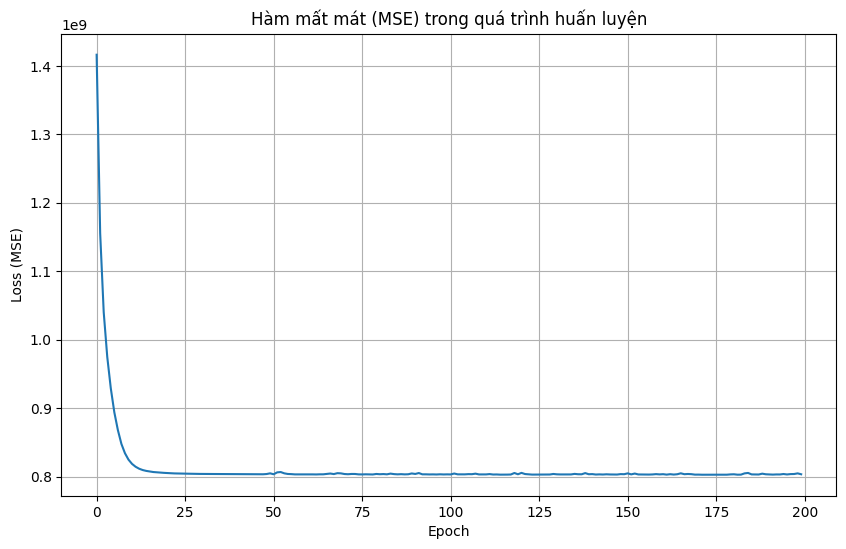

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Hàm mất mát (MSE) trong quá trình huấn luyện')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [80]:
y_train_pred_lr = model_lr.predict(x_train)
y_val_pred_lr = model_lr.predict(x_val)

6643/6643 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
836/836 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
print("\n===== Đánh giá trên tập huấn luyện (LR) =====")

mse_train_lr = mean_squared_error(y_train, y_train_pred_lr)
rmse_train_lr = np.sqrt(mse_train_lr)
mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
r2_train_lr = r2_score(y_train, y_train_pred_lr)

print(f"MSE trên tập train: {mse_train_lr:.4f}")
print(f"RMSE trên tập train: {rmse_train_lr:.4f}")
print(f"MAE trên tập train: {mae_train_lr:.4f}")
print(f"R-squared trên tập train: {r2_train_lr:.4f}")

print("\n===== Đánh giá trên tập validation (LR) =====")
mse_val_lr = mean_squared_error(y_val, y_val_pred_lr)
rmse_val_lr = np.sqrt(mse_val_lr)
mae_val_lr = mean_absolute_error(y_val, y_val_pred_lr)
r2_val_lr = r2_score(y_val, y_val_pred_lr)
print(f"MSE trên tập validation: {mse_val_lr:.4f}")
print(f"RMSE trên tập validation: {rmse_val_lr:.4f}")
print(f"MAE trên tập validation: {mae_val_lr:.4f}")
print(f"R-squared trên tập validation: {r2_val_lr:.4f}")

# xgboost

In [53]:
from xgboost import XGBRegressor
import pickle

param_grid_xgb = {
    'n_estimators': [750],      # 400 500 800 700 750
    'max_depth': [4],           # 3 4
    'learning_rate': [0.05],    # 0.05
    'reg_alpha': [11], # 10 12 11
    'reg_lambda': [2],   #  1 100 50 2           
}


xgb_model = XGBRegressor(
    random_state=42,
)

grid_search_xgb = GridSearchCV(
    xgb_model,
    param_grid_xgb,
    cv=3, # 3 5
    n_jobs=4,
    verbose=2
)

grid_search_xgb.fit(x_train, y_train)

model = grid_search_xgb.best_estimator_


Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [54]:
model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [55]:
y_train_pred_xgb = model.predict(x_train)
y_val_pred_xgb = model.predict(x_val)
y_test_pred_xgb = model.predict(x_test)

In [56]:
print("\n===== Đánh giá trên tập huấn luyện (XGBoost) =====")

mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
rmse_train_xgb = np.sqrt(mse_train_xgb)
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)

print(f"MSE trên tập train: {mse_train_xgb:.4f}")
print(f"RMSE trên tập train: {rmse_train_xgb:.4f}")
print(f"MAE trên tập train: {mae_train_xgb:.4f}")
print(f"R-squared trên tập train: {r2_train_xgb:.4f}")

print("\n===== Đánh giá trên tập validation (XGBoost) =====")
mse_val_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_val_xgb = np.sqrt(mse_val_xgb)
mae_val_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
r2_val_xgb = r2_score(y_val, y_val_pred_xgb)
print(f"MSE trên tập validation: {mse_val_xgb:.4f}")
print(f"RMSE trên tập validation: {rmse_val_xgb:.4f}")
print(f"MAE trên tập validation: {mae_val_xgb:.4f}")
print(f"R-squared trên tập validation: {r2_val_xgb:.4f}")

print("\n===== Đánh giá trên tập test (XGBoost) =====")
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
rmse_test_xgb = np.sqrt(mse_test_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)
print(f"MSE trên tập test: {mse_test_xgb:.4f}")
print(f"RMSE trên tập test: {rmse_test_xgb:.4f}")
print(f"MAE trên tập test: {mae_test_xgb:.4f}")
print(f"R-squared trên tập test: {r2_test_xgb:.4f}")


===== Đánh giá trên tập huấn luyện (XGBoost) =====
MSE trên tập train: 25103282.0178
RMSE trên tập train: 5010.3176
MAE trên tập train: 1827.1315
R-squared trên tập train: 0.9755

===== Đánh giá trên tập validation (XGBoost) =====
MSE trên tập validation: 84414881.8297
RMSE trên tập validation: 9187.7572
MAE trên tập validation: 1952.4735
R-squared trên tập validation: 0.8742

===== Đánh giá trên tập test (XGBoost) =====
MSE trên tập test: 354520802.9367
RMSE trên tập test: 18828.7228
MAE trên tập test: 2061.6793
R-squared trên tập test: 0.6191


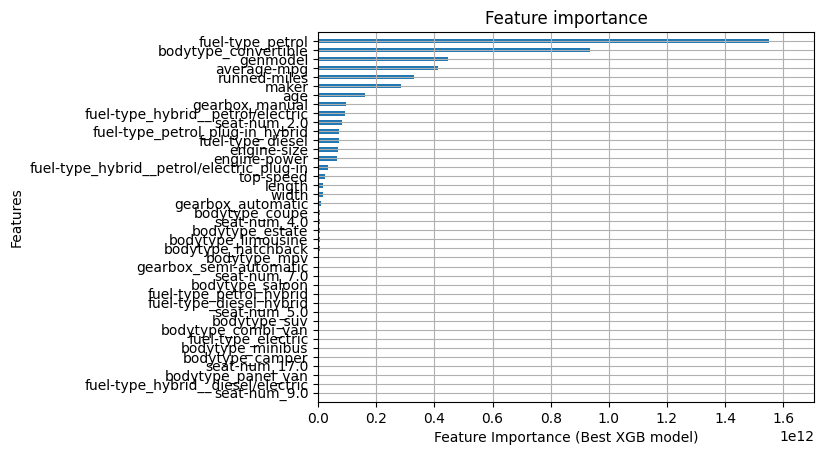

In [57]:
from xgboost import plot_importance

plot_importance(model, importance_type='gain', height=0.5, show_values=False, xlabel="Feature Importance (Best XGB model)")
plt.show()

# random forest regressor

In [257]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'n_estimators': [200, 400],         
    'max_depth': [3, 4, 5],        
    # 'min_samples_split': [15, 30],
    # 'min_samples_leaf': [15, 30]    
}


rf_model = RandomForestRegressor(
    random_state=42,
    verbose=1
)

grid_search_rf = GridSearchCV(
    rf_model,
    param_grid_rf,
    cv=3,
    n_jobs=4,
    verbose=1
)

y_train_flat = y_train


In [ ]:

print("Bắt đầu huấn luyện Random Forest Regressor...")
#grid_search_rf.fit(x_train, y_train)
rf_model = grid_search_rf.fit(x_train, y_train_flat)
print("Huấn luyện hoàn tất.")

In [21]:
# Dự đoán trên tập huấn luyện và tập validation

rf_model = rf_model.best_estimator_

y_train_pred_rf = rf_model.predict(x_train)
y_val_pred_rf = rf_model.predict(x_val)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


In [ ]:
print("\n===== Đánh giá trên tập huấn luyện (Random Forest) =====")
mse_train_rf = mean_squared_error(y_train_flat, y_train_pred_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = mean_absolute_error(y_train_flat, y_train_pred_rf)
r2_train_rf = r2_score(y_train_flat, y_train_pred_rf)

print(f"MSE trên tập train: {mse_train_rf:.4f}")
print(f"RMSE trên tập train: {rmse_train_rf:.4f}")
print(f"MAE trên tập train: {mae_train_rf:.4f}")
print(f"R-squared trên tập train: {r2_train_rf:.4f}")


print("\n===== Đánh giá trên tập validation (Random Forest) =====")
y_val_flat = y_val

mse_val_rf = mean_squared_error(y_val_flat, y_val_pred_rf)
rmse_val_rf = np.sqrt(mse_val_rf)
mae_val_rf = mean_absolute_error(y_val_flat, y_val_pred_rf)
r2_val_rf = r2_score(y_val_flat, y_val_pred_rf)

print(f"MSE trên tập validation: {mse_val_rf:.4f}")
print(f"RMSE trên tập validation: {rmse_val_rf:.4f}")
print(f"MAE trên tập validation: {mae_val_rf:.4f}")
print(f"R-squared trên tập validation: {r2_val_rf:.4f}")


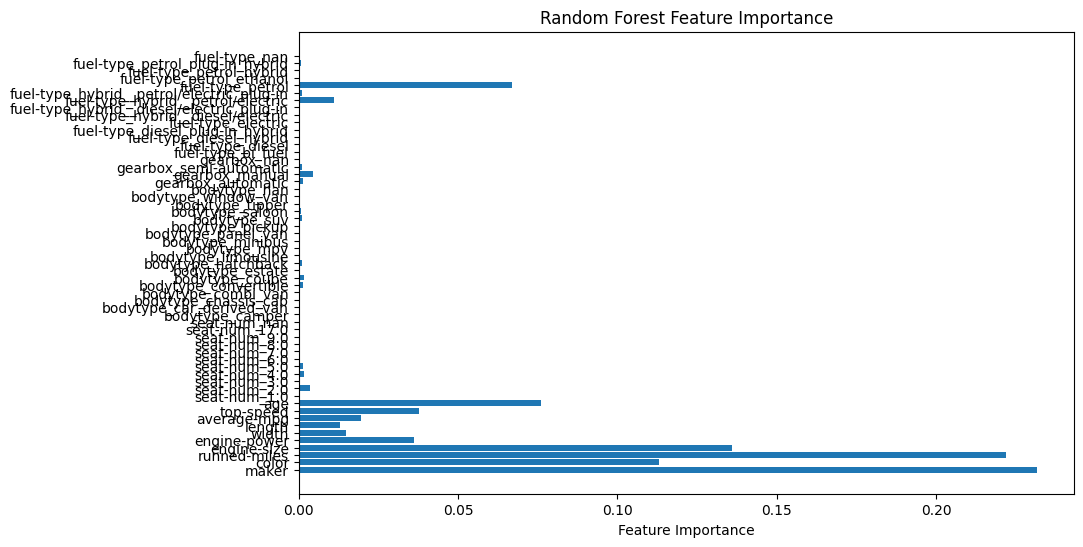

In [23]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = x_train.columns

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()